In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0810"
name_notebook = day + "-mh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_8_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/np.max(number_list)*10
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_final_11,
    measurement = qn.parts.Measurement('Z', (n_aminoacids-1)//2),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

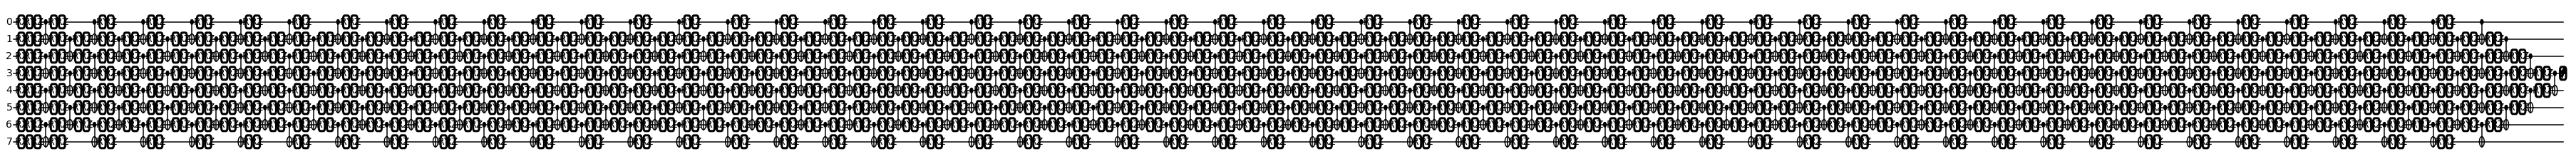

In [10]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [11]:
import torch.nn as nn
import torch
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [12]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [13]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [14]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.0537],
        [-0.1114]], grad_fn=<AddmmBackward>)
tensor([-0.1114], grad_fn=<AddBackward0>)


In [15]:
model.keep_track_params=False

In [16]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.2},
    num_epochs = 100,                
    batch_size = 32,
    # initialization_options = [
    #     {
    #         'type': 'normal_',
    #         'layer': len(model.model)-1, 
    #         'name': 'bias',
    #         'options': {'mean': 100, 'std': 10},
    #     },{
    #         'type': 'normal_',
    #         'layer': len(model.model)-1,
    #         'name': 'weight',
    #         'options': {'mean': 200, 'std': 10},
    #     },
    # ]
)

Epoch [0/100], Loss: 1.0173, Loss validation: 1.0185


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: 3.5257, 	 target: 1.2085, 	 loss: 1.9174
	 Validation string, 	 i: 1; 	 prediction: 3.4291, 	 target: 4.2057, 	 loss: 0.1847
	 Validation string, 	 i: 2; 	 prediction: 3.4826, 	 target: 1.0491, 	 loss: 2.3196
Epoch [1/100], Loss: 0.5148, Loss validation: 0.4850, Time remaining: ~10.0h 55.0m 11s
	 Validation string, 	 i: 0; 	 prediction: 3.4904, 	 target: 1.2085, 	 loss: 1.8882
	 Validation string, 	 i: 1; 	 prediction: 3.5046, 	 target: 4.2057, 	 loss: 0.1667
	 Validation string, 	 i: 2; 	 prediction: 3.1236, 	 target: 1.0491, 	 loss: 1.9773
Epoch [2/100], Loss: 0.5017, Loss validation: 0.4796, Time remaining: ~9.0h 55.0m 36s
	 Validation string, 	 i: 0; 	 prediction: 3.4851, 	 target: 1.2085, 	 loss: 1.8838
	 Validation string, 	 i: 1; 	 prediction: 3.5017, 	 target: 4.2057, 	 loss: 0.1674
	 Validation string, 	 i: 2; 	 prediction: 3.5373, 	 target: 1.0491, 	 loss: 2.3717
Epoch [3/100], Loss: 0.5012, Loss validation: 0.4848, Time remaining: ~

In [17]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0810/txts/0810-mh_em_1qm_model_str_5.txt


Saved in:  peptide-QML/checkpoints/0810/plots/0810-mh_em_1qm_losses_batches_5.png


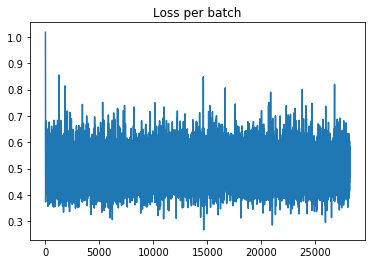

Saved in:  peptide-QML/checkpoints/0810/plots/0810-mh_em_1qm_losses_epoch_5.png


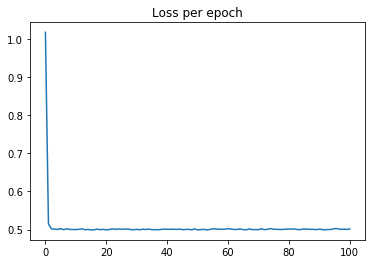

Saved in:  peptide-QML/checkpoints/0810/plots/0810-mh_em_1qm_losses_epoch_validation_5.png


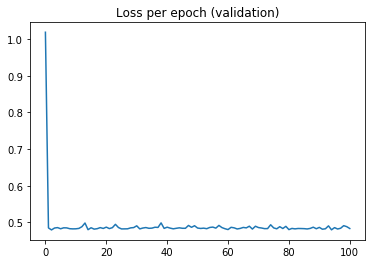

In [18]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

In [23]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

TypeError: object of type 'NoneType' has no len()

In [ ]:
# model.plot_parameter(layer='7.weights', index=50)

In [24]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0810/models/0810-mh_em_1qm_5.pth


The file peptide-QML/checkpoints/0810/plots/0810-mh_em_1qm_validation_5.png already exists, it will be replaced
Saved in:  peptide-QML/checkpoints/0810/plots/0810-mh_em_1qm_validation_5.png


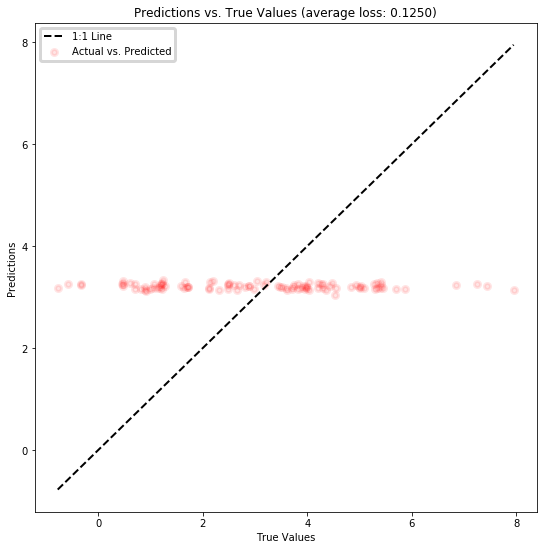

In [25]:
model.plot_validation(save=True, fig_size=(9,9), percentatge=0.1)

In [26]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=0.1)

i: 0, 		 target: 1.2085, 	 prediction: 3.2481, 	 loss: 1.6876
i: 1, 		 target: 2.1149, 	 prediction: 3.1530, 	 loss: 0.4909
i: 2, 		 target: 4.2601, 	 prediction: 3.2624, 	 loss: 0.2342
i: 3, 		 target: 5.4525, 	 prediction: 3.1863, 	 loss: 0.4156
i: 4, 		 target: 0.4727, 	 prediction: 3.2479, 	 loss: 5.8703
i: 5, 		 target: 5.3038, 	 prediction: 3.1513, 	 loss: 0.4058
i: 6, 		 target: 7.2482, 	 prediction: 3.2579, 	 loss: 0.5505
i: 7, 		 target: 1.7112, 	 prediction: 3.1877, 	 loss: 0.8628
i: 8, 		 target: 2.1105, 	 prediction: 3.1802, 	 loss: 0.5069
i: 9, 		 target: 3.5118, 	 prediction: 3.1966, 	 loss: 0.0898
i: 10, 		 target: 4.2057, 	 prediction: 3.1836, 	 loss: 0.2430
i: 11, 		 target: 7.9475, 	 prediction: 3.1417, 	 loss: 0.6047
i: 12, 		 target: 3.7404, 	 prediction: 3.2270, 	 loss: 0.1373
i: 13, 		 target: 3.9884, 	 prediction: 3.1729, 	 loss: 0.2045
i: 14, 		 target: 0.7019, 	 prediction: 3.2603, 	 loss: 3.6448
i: 15, 		 target: 4.2942, 	 prediction: 3.1818, 	 loss: 0.2590
i:

In [27]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main d295cd4f] data trained model
 7 files changed, 142 insertions(+)
 create mode 100644 checkpoints/0810/models/0810-mh_em_1qm_5.pth
 create mode 100644 checkpoints/0810/plots/0810-mh_em_1qm_losses_batches_5.png
 create mode 100644 checkpoints/0810/plots/0810-mh_em_1qm_losses_epoch_5.png
 create mode 100644 checkpoints/0810/plots/0810-mh_em_1qm_losses_epoch_validation_5.png
 create mode 100644 checkpoints/0810/plots/0810-mh_em_1qm_validation_5.png
 create mode 100644 checkpoints/0810/txts/0810-mh_em_1qm_model_str_5.txt
 create mode 100644 checkpoints/0810/txts/0810-mh_em_1qm_validation_5.txt
Enumerating objects: 20, done.
Counting objects: 100% (20/20), done.
Delta compression using up to 24 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 74.44 KiB | 8.27 MiB/s, done.
Total 14 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To github.com:raulconchello/peptide-QML.git
   a3aaaaa7..d295cd4f  main -> ma